# Carga del DS y funciones

In [ ]:
#ejecutar desde colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importar librerias y funciones necesarias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import ast
#Libreria Imblearan para manejo de datos desbalanceados
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,EditedNearestNeighbours
from imblearn.combine import SMOTEENN,SMOTETomek

#Modelos a usar
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, make_scorer,confusion_matrix, f1_score, balanced_accuracy_score, precision_score,recall_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV,train_test_split,ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [ ]:
def kfold_model_selection(x, y, clasificador,scaler, parameters,n_split=5,random_state=12):
  '''
  Función para hacer la exploración de parámetros usando validación cruzada
  '''
  param_grid = ParameterGrid(parameters)
  columns=['balanced_acc_mean_test','f1_mean_test','recall_mean_test','specificity_mean_test',
  'balanced_acc_std_test','f1_std_test','recall_std_test','specificity_std_test']

  resultados=np.zeros((len(param_grid),len(columns)))

  for c,params in enumerate(param_grid):
    clasificador.set_params(**params)
    test_score=np.zeros((n_split,4))
    i=0
    for train_index, test_index in StratifiedKFold(n_split,shuffle=True,random_state=random_state,).split(x,y):
      x_train,x_test=x[train_index],x[test_index]
      y_train,y_test=y[train_index],y[test_index]
      scaler.fit(x_train)
      x_train = scaler.transform(x_train)
      x_test = scaler.transform(x_test)

      clasificador.fit(x_train, y_train)

      y_pred=clasificador.predict(x_test)
      test_score[i,0] = balanced_accuracy_score(y_test,y_pred)
      test_score[i,1] = f1_score(y_test,y_pred,average='weighted')
      test_score[i,2] = recall_score(y_test,y_pred)
      #specificity
      tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
      test_score[i,3] = tn / (tn+fp)
      
      i+=1
    resultados[c] = np.concatenate((test_score.mean(axis=0),test_score.std(axis=0)),axis=0)
    print('kfold terminado: ',params)
  return pd.DataFrame(data=resultados,index=list(param_grid),columns=columns)

def model_comparison_test(x_train, x_test, y_train, y_test,clasificador,scaler,parameters,random_state=12):
  '''
  Función para probar los modelos con el mismo conjunto de entrenamiento 
  '''
  columns=['balanced_acc_test','f1_test','recall_test','specificity_test']
  test_score = np.zeros((len(parameters),len(columns)))
  for c,params in enumerate(parameters):

    clasificador.set_params(**params)
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    clasificador.fit(x_train, y_train)

    y_pred=clasificador.predict(x_test)
    test_score[c,0] = balanced_accuracy_score(y_test,y_pred)
    test_score[c,1] = f1_score(y_test,y_pred,average='weighted')
    test_score[c,2] = recall_score(y_test,y_pred)
    #specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    test_score[c,3] = tn / (tn+fp)
    print('kfold terminado: ',params)
     
  return pd.DataFrame(data=test_score,index=list(parameters),columns=columns)


In [ ]:
# path_train = '../DataBase/dataset-1.0.1/training_data/'
# path_db = '../DataBase/dataset-1.0.1/'
df=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/scripts/patient_info.csv', index_col=0) #infortmacion del paciente

In [ ]:
#cargar carecteristicas de las señales
w=0.2
resamp=1000
signal_features=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/scripts/extracted_features/'+'features'+str(w)+str(resamp)+'.csv', index_col=0)

In [ ]:
# Combinar las señales con las características de los pacientes
signal_features['id']=signal_features['id'].apply(lambda x: int(x))
df_nuevo = signal_features.merge(df,on='id')

In [ ]:
df_nuevo.columns

Index(['id', 'AV', 'MV', 'PV', 'TV', 'Phc', ' mfcc1 min', ' mfcc2 min',
       ' mfcc3 min', ' mfcc4 min',
       ...
       '#Diastolic murmur timing', '#Diastolic murmur shape',
       '#Diastolic murmur grading', '#Diastolic murmur pitch',
       '#Diastolic murmur quality', '#Campaign', 'frequency', 'num_loc',
       'locations', 'label'],
      dtype='object', length=118)

In [ ]:
#crear x, y para entenar el modelo clasificacion binaria de señales.
cols_x=''' mfcc1 min, mfcc2 min, mfcc3 min, mfcc4 min, mfcc5 min, mfcc6 min, mfcc7 min, mfcc8 min, mfcc9 min, mfcc10 min, mfcc11 min, mfcc12 min, mfcc13 min, zcr min, rms min, sr90 min, sr10 min, sc min,
mfcc1 max, mfcc2 max, mfcc3 max, mfcc4 max, mfcc5 max, mfcc6 max, mfcc7 max, mfcc8 max, mfcc9 max, mfcc10 max, mfcc11 max, mfcc12 max, mfcc13 max, zcr max, rms max, sr90 max, sr10 max, sc max,
mfcc1 med, mfcc2 med, mfcc3 med, mfcc4 med, mfcc5 med, mfcc6 med, mfcc7 med, mfcc8 med, mfcc9 med, mfcc10 med, mfcc11 med, mfcc12 med, mfcc13 med, zcr med, rms med, sr90 med, sr10 med, sc med,
mfcc1 mean, mfcc2 mean, mfcc3 mean, mfcc4 mean, mfcc5 mean, mfcc6 mean, mfcc7 mean, mfcc8 mean, mfcc9 mean, mfcc10 mean, mfcc11 mean, mfcc12 mean, mfcc13 mean, zcr mean, rms mean, sr90 mean, sr10 mean, sc mean,
mfcc1 std, mfcc2 std, mfcc3 std, mfcc4 std, mfcc5 std, mfcc6 std, mfcc7 std, mfcc8 std, mfcc9 std, mfcc10 std, mfcc11 std, mfcc12 std, mfcc13 std, zcr std, rms std, sr90 std, sr10 std, sc std'''
cols_x = cols_x.replace('\n',' ').split(',')
x_full = df_nuevo[cols_x].values
y_full=[]
for i,val in df_nuevo[['AV', 'MV', 'PV', 'TV', 'Phc','#Murmur locations']].iterrows():
    if pd.isna(val['#Murmur locations']):
        y_full.append(0)
    else:
        locs = val['#Murmur locations'].split('+')
        #print(locs)
        if val[val==1].index.values[0] in locs:
            y_full.append(1)
        else:
            y_full.append(0)
    #print(val)
y_full=np.array(y_full)
# conjuntos de entrenamiento y prueba para todo el proceso  
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.20, random_state=12, stratify=y_full)

In [ ]:
print('Todos los datos:\n', 'Cantidad: ', len(y_full),'Present: ',sum(y_full), 'Porcentaje: ',sum(y_full)/len(y_full))
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_train),'Present: ',sum(y_train), 'Porcentaje: ',sum(y_train)/len(y_train))
print('Datos Prueba:\n', 'Cantidad: ', len(y_test),'Present: ',sum(y_test), 'Porcentaje: ',sum(y_test)/len(y_test))

Todos los datos:
 Cantidad:  3163 Present:  499 Porcentaje:  0.15776161871640848
Datos Entrenamiento:
 Cantidad:  2530 Present:  399 Porcentaje:  0.15770750988142293
Datos Prueba:
 Cantidad:  633 Present:  100 Porcentaje:  0.1579778830963665


# 1.0 Entrenamiento sin aplicar nada

Primero se hacen un entrenamiento con todas las características extraidas.

## SVM

In [ ]:
# Exploracion de parametros para SVM, se usa x_full para la validación cruzada, luego se reentrenara el mejor con solo x_train
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
parameters={'C':[0.3,0.8,5,15,80,200],
            'kernel':['poly','rbf'],
            'gamma':['scale']}
df_svm=kfold_model_selection(x_full, y_full, clf,scaler, parameters, n_split=5)

kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 15, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 80, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 80, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 200, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 200, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Se guardan los resultados de la exploración en un archivo csv por cada modelo
# df_svm.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/smv_simple.csv')
df_svm.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/smv_simple.csv', mode='a', header=False)

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/smv_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
df_model=model_comparison_test(x_train, x_test, y_train, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.728049,0.776280,0.70,0.756098
"{'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}",0.722739,0.779484,0.68,0.765478
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.741492,0.789172,0.71,0.772983
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.719615,0.780433,0.67,0.769231
"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.751191,0.812430,0.69,0.812383
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}",0.727129,0.805576,0.64,0.814259
"{'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}",0.743996,0.797682,0.70,0.787992
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.736191,0.807586,0.66,0.812383
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}",0.735872,0.797034,0.68,0.791745
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.736201,0.822625,0.63,0.842402


              precision    recall  f1-score   support

      Absent       0.93      0.81      0.87       533
     Present       0.41      0.69      0.51       100

    accuracy                           0.79       633
   macro avg       0.67      0.75      0.69       633
weighted avg       0.85      0.79      0.81       633



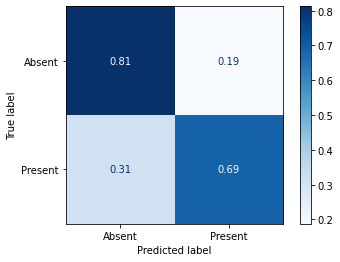

In [ ]:
clf = make_pipeline(scaler, clf.set_params(**{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}))
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

## MLP

In [ ]:
scaler = MinMaxScaler((0,1))
clf=MLPClassifier(max_iter=2000,early_stopping=True,n_iter_no_change=20,random_state=12)
parameters={'hidden_layer_sizes':[40,60,80,100],# comence desde 5 pero habian errores
            'activation':['tanh','relu'],
            'learning_rate_init':[0.01],
            'batch_size':[200,400]
              }
df_model=kfold_model_selection(x_full, y_full, clf,scaler, parameters, n_split=5)

kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 80, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 80, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 

In [ ]:
df_model.sort_values('f1_mean_test')

In [ ]:
# df_model.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/mlp_simple.csv')
df_model.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/mlp_simple.csv', mode='a', header=False)

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/mlp_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]#toco <0.65
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=MLPClassifier(max_iter=2000,early_stopping=True,n_iter_no_change=20,random_state=12)
df_model=model_comparison_test(x_train, x_test, y_train, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 6

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.724362,0.876424,0.49,0.958724
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.665310,0.866260,0.34,0.990619
"{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}",0.638433,0.851273,0.29,0.986867
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.614371,0.839573,0.24,0.988743
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.614371,0.839573,0.24,0.988743
"{'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.713734,0.866392,0.48,0.947467
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.629371,0.847452,0.27,0.988743
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.629371,0.847452,0.27,0.988743
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}",0.725300,0.877776,0.49,0.960600
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 80, 'learning_rate_init': 0.01}",0.701867,0.874650,0.43,0.973734


              precision    recall  f1-score   support

      Absent       0.91      0.96      0.93       533
     Present       0.69      0.49      0.57       100

    accuracy                           0.88       633
   macro avg       0.80      0.72      0.75       633
weighted avg       0.87      0.88      0.88       633



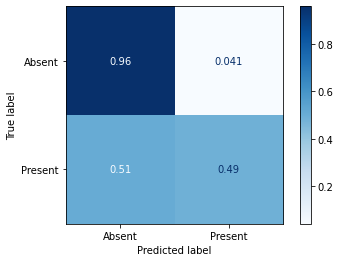

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}))
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

## RF

In [ ]:
scaler = MinMaxScaler((0,1))
clf=RandomForestClassifier(class_weight='balanced',random_state=12) 
parameters={'n_estimators':[20,80,100], 
            'criterion':['gini'], 
            'min_samples_split':[60,70,100],
            'max_features':['auto']}
df_model=kfold_model_selection(x_full, y_full, clf,scaler, parameters, n_split=5)

kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 60, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 60, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 60, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}


In [ ]:
# df_model.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/rf_simple.csv')
df_model.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/rf_simple.csv', mode='a', header=False)

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/rf_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=RandomForestClassifier(class_weight='balanced',random_state=12) 
df_model=model_comparison_test(x_train, x_test, y_train, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}
kfold termin

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}",0.701529,0.835131,0.51,0.893058
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}",0.698405,0.835755,0.50,0.896811
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}",0.718086,0.833004,0.56,0.876173
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}",0.715901,0.834962,0.55,0.881801
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}",0.710281,0.842012,0.52,0.900563
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}",0.700910,0.843891,0.49,0.911820
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}",0.707148,0.828173,0.54,0.874296
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}",0.689034,0.837519,0.47,0.908068
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}",0.708724,0.849620,0.50,0.917448
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 10}",0.686520,0.815372,0.51,0.863039


              precision    recall  f1-score   support

      Absent       0.91      0.88      0.89       533
     Present       0.46      0.56      0.50       100

    accuracy                           0.83       633
   macro avg       0.69      0.72      0.70       633
weighted avg       0.84      0.83      0.83       633



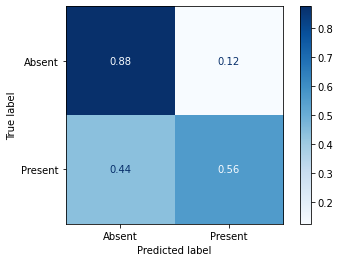

In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
clf = make_pipeline(scaler, 
                    clf.set_params(**{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}))
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

## LR

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
parameters={'C':[120,150,250,300],
            'solver':['newton-cg','lbfgs']}
df_model=kfold_model_selection(x_full, y_full, clf,scaler, parameters, n_split=5)

kfold terminado:  {'C': 120, 'solver': 'newton-cg'}
kfold terminado:  {'C': 120, 'solver': 'lbfgs'}
kfold terminado:  {'C': 150, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'newton-cg'}
kfold terminado:  {'C': 250, 'solver': 'lbfgs'}
kfold terminado:  {'C': 300, 'solver': 'newton-cg'}
kfold terminado:  {'C': 300, 'solver': 'lbfgs'}


In [ ]:
# df_model.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/lr_simple.csv')
df_model.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/lr_simple.csv', mode='a', header=False)

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/lr_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
df_model=model_comparison_test(x_train, x_test, y_train, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 120, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'lbfgs'}
kfold terminado:  {'C': 100, 'solver': 'newton-cg'}
kfold terminado:  {'C': 100, 'solver': 'lbfgs'}
kfold terminado:  {'C': 120, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'newton-cg'}
kfold terminado:  {'C': 300, 'solver': 'newton-cg'}
kfold terminado:  {'C': 200, 'solver': 'lbfgs'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 120, 'solver': 'newton-cg'}",0.735544,0.770705,0.73,0.741088
"{'C': 150, 'solver': 'newton-cg'}",0.735544,0.770705,0.73,0.741088
"{'C': 150, 'solver': 'lbfgs'}",0.735544,0.770705,0.73,0.741088
"{'C': 100, 'solver': 'newton-cg'}",0.736482,0.771977,0.73,0.742964
"{'C': 100, 'solver': 'lbfgs'}",0.736482,0.771977,0.73,0.742964
"{'C': 120, 'solver': 'lbfgs'}",0.736482,0.771977,0.73,0.742964
"{'C': 250, 'solver': 'lbfgs'}",0.737420,0.773249,0.73,0.744841
"{'C': 250, 'solver': 'newton-cg'}",0.737420,0.773249,0.73,0.744841
"{'C': 300, 'solver': 'newton-cg'}",0.736482,0.771977,0.73,0.742964
"{'C': 200, 'solver': 'lbfgs'}",0.737420,0.773249,0.73,0.744841


              precision    recall  f1-score   support

      Absent       0.94      0.74      0.83       533
     Present       0.35      0.73      0.47       100

    accuracy                           0.74       633
   macro avg       0.64      0.74      0.65       633
weighted avg       0.84      0.74      0.77       633



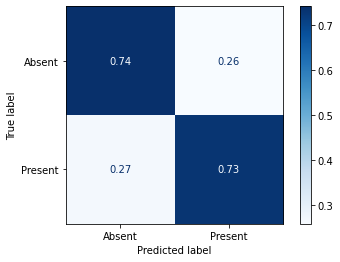

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'C': 120, 'solver': 'newton-cg'}))
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

## KNN

In [ ]:
scaler = MinMaxScaler((0,1))
clf=KNeighborsClassifier()
parameters={'n_neighbors':[3,4,5],
            'weights':['uniform'],
            'algorithm':['ball_tree'],
            'leaf_size':[5,10,20,30,40,90]}
df_model=kfold_model_selection(x_full, y_full, clf,scaler, parameters, n_split=5)

kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 4, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 5, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 4, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 4, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 5, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weig

In [ ]:
# df_model.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/knn_simple.csv')
df_model.to_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/knn_simple.csv', mode='a', header=False)

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/knn_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=KNeighborsClassifier()
df_model=model_comparison_test(x_train, x_test, y_train, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'wei

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}",0.628734,0.829842,0.31,0.947467
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}",0.628734,0.829842,0.31,0.947467
"{'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}",0.628734,0.829842,0.31,0.947467
"{'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}",0.628734,0.829842,0.31,0.947467
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}",0.628734,0.829842,0.31,0.947467
"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}",0.628734,0.829842,0.31,0.947467
"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.646520,0.800670,0.43,0.863039
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.646520,0.800670,0.43,0.863039
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.646520,0.800670,0.43,0.863039
"{'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.646520,0.800670,0.43,0.863039


              precision    recall  f1-score   support

      Absent       0.89      0.86      0.88       533
     Present       0.37      0.43      0.40       100

    accuracy                           0.79       633
   macro avg       0.63      0.65      0.64       633
weighted avg       0.81      0.79      0.80       633



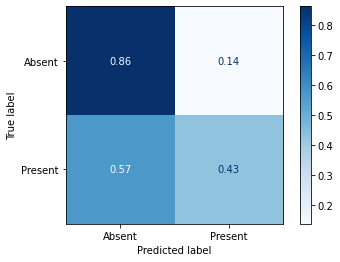

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}))
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

# 1.1 Técnicas de Muestreo

## OverSampling

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


### SVM

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/smv_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.739934,0.797363,0.69,0.789869
"{'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}",0.719925,0.775716,0.68,0.759850
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.744634,0.818849,0.66,0.829268
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.745872,0.800197,0.70,0.791745
"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.742148,0.840567,0.61,0.874296
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}",0.720572,0.811793,0.61,0.831144
"{'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}",0.739325,0.821798,0.64,0.838649
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.714944,0.804356,0.61,0.819887
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}",0.734015,0.824689,0.62,0.848030
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.723715,0.840536,0.56,0.887430


              precision    recall  f1-score   support

      Absent       0.93      0.79      0.86       533
     Present       0.39      0.70      0.50       100

    accuracy                           0.78       633
   macro avg       0.66      0.75      0.68       633
weighted avg       0.85      0.78      0.80       633



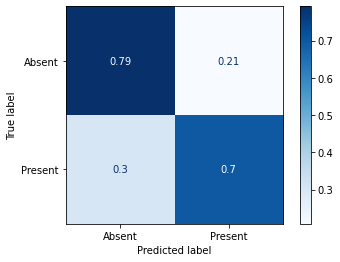

In [ ]:
clf = make_pipeline(scaler, clf.set_params(**{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### MLP

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/mlp_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]#toco <0.65
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=MLPClassifier(max_iter=2000,early_stopping=True,n_iter_no_change=20,random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 6

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.731492,0.786063,0.69,0.772983
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.714606,0.763385,0.69,0.739212
"{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}",0.708368,0.780704,0.64,0.776735
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.718996,0.789764,0.65,0.787992
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.718996,0.789764,0.65,0.787992
"{'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.707730,0.759338,0.68,0.735460
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.734944,0.810952,0.65,0.819887
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.734944,0.810952,0.65,0.819887
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}",0.717430,0.782617,0.66,0.774859
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 80, 'learning_rate_init': 0.01}",0.734325,0.820125,0.63,0.838649


              precision    recall  f1-score   support

      Absent       0.93      0.77      0.84       533
     Present       0.36      0.69      0.48       100

    accuracy                           0.76       633
   macro avg       0.65      0.73      0.66       633
weighted avg       0.84      0.76      0.79       633



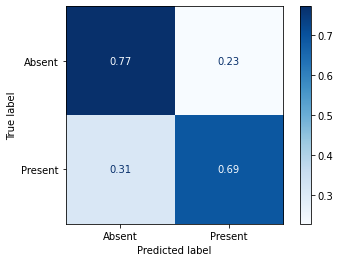

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### RF

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/rf_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=RandomForestClassifier(class_weight='balanced',random_state=12) 
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}
kfold termin

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}",0.685281,0.832543,0.47,0.900563
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}",0.685910,0.838069,0.46,0.911820
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}",0.684343,0.831305,0.47,0.898687
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}",0.689343,0.833215,0.48,0.898687
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}",0.688096,0.836272,0.47,0.906191
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}",0.687786,0.840572,0.46,0.915572
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}",0.689962,0.824598,0.50,0.879925
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}",0.691529,0.831386,0.49,0.893058
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}",0.700600,0.848283,0.48,0.921201
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 10}",0.696529,0.833263,0.50,0.893058


              precision    recall  f1-score   support

      Absent       0.90      0.92      0.91       533
     Present       0.53      0.48      0.51       100

    accuracy                           0.85       633
   macro avg       0.72      0.70      0.71       633
weighted avg       0.85      0.85      0.85       633



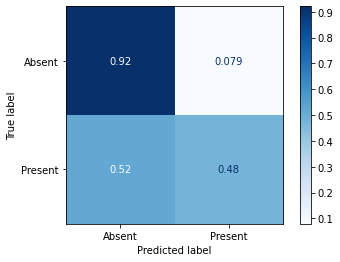

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### LR

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/lr_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 120, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'lbfgs'}
kfold terminado:  {'C': 100, 'solver': 'newton-cg'}
kfold terminado:  {'C': 100, 'solver': 'lbfgs'}
kfold terminado:  {'C': 120, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'newton-cg'}
kfold terminado:  {'C': 300, 'solver': 'newton-cg'}
kfold terminado:  {'C': 200, 'solver': 'lbfgs'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 120, 'solver': 'newton-cg'}",0.744296,0.777304,0.74,0.748593
"{'C': 150, 'solver': 'newton-cg'}",0.742420,0.774758,0.74,0.744841
"{'C': 150, 'solver': 'lbfgs'}",0.742420,0.774758,0.74,0.744841
"{'C': 100, 'solver': 'newton-cg'}",0.744296,0.777304,0.74,0.748593
"{'C': 100, 'solver': 'lbfgs'}",0.744296,0.777304,0.74,0.748593
"{'C': 120, 'solver': 'lbfgs'}",0.744296,0.777304,0.74,0.748593
"{'C': 250, 'solver': 'lbfgs'}",0.739296,0.775790,0.73,0.748593
"{'C': 250, 'solver': 'newton-cg'}",0.740235,0.777060,0.73,0.750469
"{'C': 300, 'solver': 'newton-cg'}",0.740235,0.777060,0.73,0.750469
"{'C': 200, 'solver': 'lbfgs'}",0.739296,0.775790,0.73,0.748593


              precision    recall  f1-score   support

      Absent       0.94      0.75      0.83       533
     Present       0.36      0.74      0.48       100

    accuracy                           0.75       633
   macro avg       0.65      0.74      0.66       633
weighted avg       0.85      0.75      0.78       633



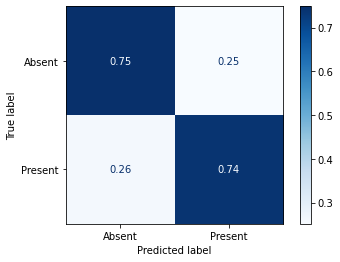

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'C': 120, 'solver': 'newton-cg'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### KNN

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/knn_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=KNeighborsClassifier()
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'wei

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}",0.607317,0.532220,0.80,0.414634
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}",0.607317,0.532220,0.80,0.414634
"{'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}",0.607317,0.532220,0.80,0.414634
"{'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}",0.607317,0.532220,0.80,0.414634
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}",0.607317,0.532220,0.80,0.414634
"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}",0.607317,0.532220,0.80,0.414634
"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.606407,0.595215,0.71,0.502814
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.606407,0.595215,0.71,0.502814
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.606407,0.595215,0.71,0.502814
"{'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.606407,0.595215,0.71,0.502814


              precision    recall  f1-score   support

      Absent       0.90      0.50      0.65       533
     Present       0.21      0.71      0.33       100

    accuracy                           0.54       633
   macro avg       0.56      0.61      0.49       633
weighted avg       0.79      0.54      0.60       633



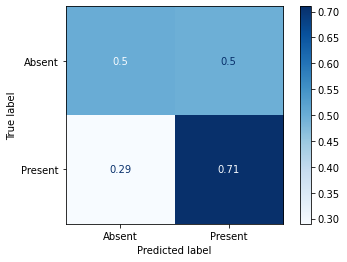

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

## Over-Under Sampling

In [ ]:
sampler = SMOTEENN(random_state=12,sampling_strategy=0.5)# under over
x_resamp, y_resamp = sampler.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  1933 Present:  839 Porcentaje:  0.4340403517847905


### SVM

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/smv_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.717430,0.782617,0.66,0.774859
"{'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}",0.713677,0.777618,0.66,0.767355
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.732120,0.792023,0.68,0.784240
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.718358,0.768439,0.69,0.746717
"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.738077,0.825128,0.63,0.846154
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}",0.723687,0.795992,0.65,0.797373
"{'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}",0.731501,0.801342,0.66,0.803002
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.720563,0.796868,0.64,0.801126
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}",0.732129,0.807209,0.65,0.814259
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.742458,0.835986,0.62,0.864916


              precision    recall  f1-score   support

      Absent       0.92      0.86      0.89       533
     Present       0.46      0.62      0.53       100

    accuracy                           0.83       633
   macro avg       0.69      0.74      0.71       633
weighted avg       0.85      0.83      0.84       633



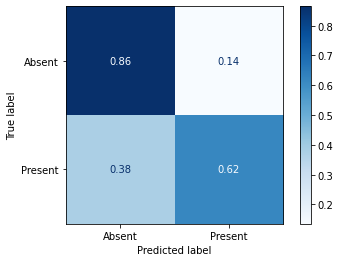

In [ ]:
clf=SVC(class_weight='balanced',random_state=12)
clf = make_pipeline(scaler, clf.set_params(**{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### MLP

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/mlp_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=MLPClassifier(max_iter=2000,early_stopping=True,n_iter_no_change=20,random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 6

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.708368,0.780704,0.64,0.776735
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.706182,0.782841,0.63,0.782364
"{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}",0.718687,0.794382,0.64,0.797373
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.708668,0.760601,0.68,0.737336
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.708668,0.760601,0.68,0.737336
"{'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.706473,0.747091,0.70,0.712946
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.699306,0.778763,0.62,0.778612
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.699306,0.778763,0.62,0.778612
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}",0.698358,0.762297,0.65,0.746717
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 80, 'learning_rate_init': 0.01}",0.716210,0.830506,0.56,0.872420


              precision    recall  f1-score   support

      Absent       0.92      0.80      0.86       533
     Present       0.37      0.64      0.47       100

    accuracy                           0.77       633
   macro avg       0.65      0.72      0.66       633
weighted avg       0.84      0.77      0.79       633



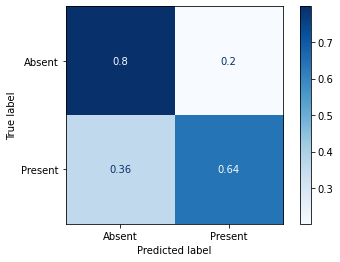

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### RF

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/rf_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=RandomForestClassifier(class_weight='balanced',random_state=12) 
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}
kfold termin

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}",0.717129,0.802294,0.62,0.814259
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}",0.718068,0.803533,0.62,0.816135
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}",0.738068,0.810086,0.66,0.816135
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}",0.726191,0.804331,0.64,0.812383
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}",0.711191,0.799407,0.61,0.812383
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}",0.734944,0.810952,0.65,0.819887
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}",0.710253,0.798171,0.61,0.810507
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}",0.726201,0.819250,0.61,0.842402
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}",0.726820,0.810153,0.63,0.823640
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 10}",0.690563,0.787066,0.58,0.801126


              precision    recall  f1-score   support

      Absent       0.93      0.82      0.87       533
     Present       0.40      0.66      0.50       100

    accuracy                           0.79       633
   macro avg       0.66      0.74      0.68       633
weighted avg       0.84      0.79      0.81       633



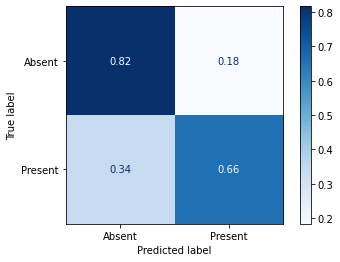

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### LR

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/lr_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 120, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'lbfgs'}
kfold terminado:  {'C': 100, 'solver': 'newton-cg'}
kfold terminado:  {'C': 100, 'solver': 'lbfgs'}
kfold terminado:  {'C': 120, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'newton-cg'}
kfold terminado:  {'C': 300, 'solver': 'newton-cg'}
kfold terminado:  {'C': 200, 'solver': 'lbfgs'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 120, 'solver': 'newton-cg'}",0.724296,0.771229,0.70,0.748593
"{'C': 150, 'solver': 'newton-cg'}",0.726482,0.768952,0.71,0.742964
"{'C': 150, 'solver': 'lbfgs'}",0.726482,0.768952,0.71,0.742964
"{'C': 100, 'solver': 'newton-cg'}",0.726173,0.773755,0.70,0.752345
"{'C': 100, 'solver': 'lbfgs'}",0.726173,0.773755,0.70,0.752345
"{'C': 120, 'solver': 'lbfgs'}",0.728358,0.771487,0.71,0.746717
"{'C': 250, 'solver': 'lbfgs'}",0.723668,0.765146,0.71,0.737336
"{'C': 250, 'solver': 'newton-cg'}",0.723668,0.765146,0.71,0.737336
"{'C': 300, 'solver': 'newton-cg'}",0.723668,0.765146,0.71,0.737336
"{'C': 200, 'solver': 'lbfgs'}",0.726482,0.768952,0.71,0.742964


              precision    recall  f1-score   support

      Absent       0.93      0.74      0.83       533
     Present       0.34      0.71      0.46       100

    accuracy                           0.74       633
   macro avg       0.64      0.73      0.64       633
weighted avg       0.84      0.74      0.77       633



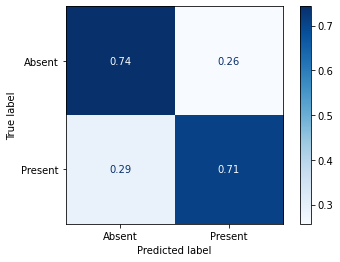

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'C': 150, 'solver': 'newton-cg'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### KNN

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/knn_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=KNeighborsClassifier()
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'wei

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}",0.640159,0.608757,0.77,0.510319
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}",0.640159,0.608757,0.77,0.510319
"{'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}",0.640159,0.608757,0.77,0.510319
"{'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}",0.640159,0.608757,0.77,0.510319
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}",0.640159,0.608757,0.77,0.510319
"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}",0.640159,0.608757,0.77,0.510319
"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.648612,0.641327,0.74,0.557223
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.648612,0.641327,0.74,0.557223
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.648612,0.641327,0.74,0.557223
"{'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.648612,0.641327,0.74,0.557223


              precision    recall  f1-score   support

      Absent       0.92      0.56      0.69       533
     Present       0.24      0.74      0.36       100

    accuracy                           0.59       633
   macro avg       0.58      0.65      0.53       633
weighted avg       0.81      0.59      0.64       633



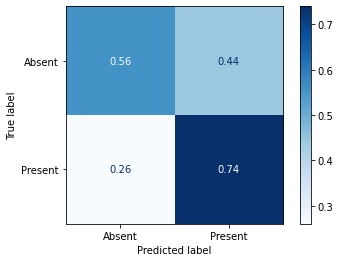

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

# 1.2 Seleccion de Características

In [ ]:
# Librerias para hacer seleccion de caracteristicas
from sklearn.feature_selection import VarianceThreshold,SelectKBest,mutual_info_classif,f_classif

La primera parte de la seleccion de caracteristicas se realizó teniendo en cuenta la varianza propia de cada caracteristica y la correlacion acumulada. Luego se exploro el uso de el estadístico f y `feature_importance` de los bosques aleatorios.

## Varianza y corr

In [ ]:
cols_x=''' mfcc1 min, mfcc2 min, mfcc3 min, mfcc4 min, mfcc5 min, mfcc6 min, mfcc7 min, mfcc8 min, mfcc9 min, mfcc10 min, mfcc11 min, mfcc12 min, mfcc13 min, zcr min, rms min, sr90 min, sr10 min, sc min,
mfcc1 max, mfcc2 max, mfcc3 max, mfcc4 max, mfcc5 max, mfcc6 max, mfcc7 max, mfcc8 max, mfcc9 max, mfcc10 max, mfcc11 max, mfcc12 max, mfcc13 max, zcr max, rms max, sr90 max, sr10 max, sc max,
mfcc1 med, mfcc2 med, mfcc3 med, mfcc4 med, mfcc5 med, mfcc6 med, mfcc7 med, mfcc8 med, mfcc9 med, mfcc10 med, mfcc11 med, mfcc12 med, mfcc13 med, zcr med, rms med, sr90 med, sr10 med, sc med,
mfcc1 mean, mfcc2 mean, mfcc3 mean, mfcc4 mean, mfcc5 mean, mfcc6 mean, mfcc7 mean, mfcc8 mean, mfcc9 mean, mfcc10 mean, mfcc11 mean, mfcc12 mean, mfcc13 mean, zcr mean, rms mean, sr90 mean, sr10 mean, sc mean,
mfcc1 std, mfcc2 std, mfcc3 std, mfcc4 std, mfcc5 std, mfcc6 std, mfcc7 std, mfcc8 std, mfcc9 std, mfcc10 std, mfcc11 std, mfcc12 std, mfcc13 std, zcr std, rms std, sr90 std, sr10 std, sc std'''
cols_x = cols_x.replace('\n',' ').split(',')
x_full = df_nuevo[cols_x].values
y_full=[]
for i,val in df_nuevo[['AV', 'MV', 'PV', 'TV', 'Phc','#Murmur locations']].iterrows():
    if pd.isna(val['#Murmur locations']):
        y_full.append(0)
    else:
        locs = val['#Murmur locations'].split('+')
        #print(locs)
        if val[val==1].index.values[0] in locs:
            y_full.append(1)
        else:
            y_full.append(0)
    #print(val)
y_full=np.array(y_full)
# conjuntos de entrenamiento y prueba para todo el proceso  
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.20, random_state=12, stratify=y_full)

In [ ]:
# Se guardan a parte los datos escalados para la selccion de carac...
scaler=MinMaxScaler((0,1))
x_t2=scaler.fit_transform(x_train)

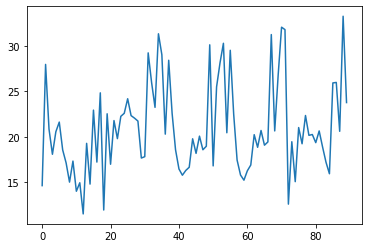

In [ ]:
# calculo de la correlacion acumulada
df_escalado = pd.DataFrame(x_t2)
corr=abs(df_escalado.corr()) #dejar todas las correlaciones en positivo 
corr_acum=corr.sum(axis=1).values
plt.plot(corr_acum)
# la correlacion acumulada maxima teorica es 90

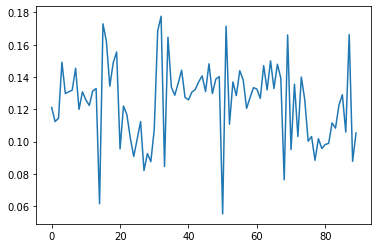

In [ ]:
x_std=x_t2.std(axis=0)
plt.plot(x_std)

In [ ]:
cols_selec=np.where((x_std>0.1))[0]
col_names = [cols_x[i] for i in cols_selec]
len(col_names)

75

In [ ]:
# se dejan solo las columnas necesarias, pero hay que tyener cuidado y recordar que se han quitado de x_train
x_train=x_train[:,cols_selec]
x_test=x_test[:,cols_selec]

### SVM

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/smv_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.738687,0.800792,0.68,0.797373
"{'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}",0.718058,0.788518,0.65,0.786116
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.759015,0.833088,0.67,0.848030
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.751191,0.812430,0.69,0.812383
"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.764343,0.860706,0.63,0.898687
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}",0.755891,0.833945,0.66,0.851782
"{'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}",0.749015,0.829747,0.65,0.848030
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.735882,0.812201,0.65,0.821764
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}",0.730582,0.830022,0.60,0.861163
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.729034,0.852677,0.55,0.908068


              precision    recall  f1-score   support

      Absent       0.93      0.85      0.89       533
     Present       0.45      0.67      0.54       100

    accuracy                           0.82       633
   macro avg       0.69      0.76      0.71       633
weighted avg       0.86      0.82      0.83       633



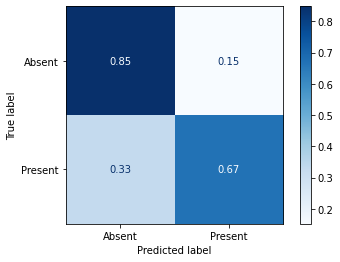

In [ ]:
clf=SVC(class_weight='balanced',random_state=12)
clf = make_pipeline(scaler, clf.set_params(**{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}	))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### MLP

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/mlp_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]#toco <0.65
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=MLPClassifier(max_iter=2000,early_stopping=True,n_iter_no_change=20,random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 6

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.716792,0.761099,0.70,0.733583
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.728358,0.771487,0.71,0.746717
"{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}",0.738386,0.820546,0.64,0.836773
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.717092,0.740096,0.74,0.694184
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.717092,0.740096,0.74,0.694184
"{'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.717092,0.740096,0.74,0.694184
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.711482,0.764388,0.68,0.742964
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.711482,0.764388,0.68,0.742964
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}",0.736801,0.782865,0.71,0.763602
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 80, 'learning_rate_init': 0.01}",0.719925,0.775716,0.68,0.759850


              precision    recall  f1-score   support

      Absent       0.93      0.76      0.84       533
     Present       0.36      0.71      0.48       100

    accuracy                           0.76       633
   macro avg       0.65      0.74      0.66       633
weighted avg       0.84      0.76      0.78       633



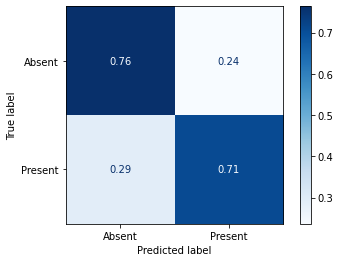

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### RF

In [ ]:
sampler = SMOTEENN(random_state=12,sampling_strategy=0.5)# under over
x_resamp, y_resamp = sampler.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  1962 Present:  828 Porcentaje:  0.42201834862385323


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/rf_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=RandomForestClassifier(class_weight='balanced',random_state=12) 
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}
kfold termin

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}",0.713696,0.807637,0.60,0.827392
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}",0.708696,0.805957,0.59,0.827392
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}",0.707129,0.798989,0.60,0.814259
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}",0.710882,0.803928,0.60,0.821764
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}",0.718386,0.813830,0.60,0.836773
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}",0.711510,0.809662,0.59,0.833021
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}",0.690253,0.791537,0.57,0.810507
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}",0.704006,0.799791,0.59,0.818011
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}",0.699944,0.799348,0.58,0.819887
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 10}",0.706501,0.793227,0.61,0.803002


              precision    recall  f1-score   support

      Absent       0.92      0.84      0.88       533
     Present       0.41      0.60      0.49       100

    accuracy                           0.80       633
   macro avg       0.66      0.72      0.68       633
weighted avg       0.84      0.80      0.81       633



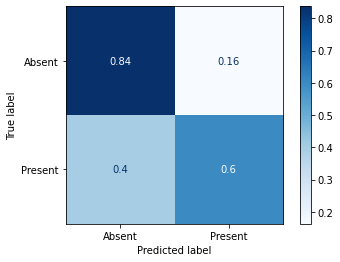

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}	))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### LR

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/lr_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 120, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'lbfgs'}
kfold terminado:  {'C': 100, 'solver': 'newton-cg'}
kfold terminado:  {'C': 100, 'solver': 'lbfgs'}
kfold terminado:  {'C': 120, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'newton-cg'}
kfold terminado:  {'C': 300, 'solver': 'newton-cg'}
kfold terminado:  {'C': 200, 'solver': 'lbfgs'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 120, 'solver': 'newton-cg'}",0.747739,0.787202,0.73,0.765478
"{'C': 150, 'solver': 'newton-cg'}",0.747739,0.787202,0.73,0.765478
"{'C': 150, 'solver': 'lbfgs'}",0.747739,0.787202,0.73,0.765478
"{'C': 100, 'solver': 'newton-cg'}",0.747739,0.787202,0.73,0.765478
"{'C': 100, 'solver': 'lbfgs'}",0.747739,0.787202,0.73,0.765478
"{'C': 120, 'solver': 'lbfgs'}",0.747739,0.787202,0.73,0.765478
"{'C': 250, 'solver': 'lbfgs'}",0.749615,0.789734,0.73,0.769231
"{'C': 250, 'solver': 'newton-cg'}",0.749615,0.789734,0.73,0.769231
"{'C': 300, 'solver': 'newton-cg'}",0.748677,0.788468,0.73,0.767355
"{'C': 200, 'solver': 'lbfgs'}",0.748677,0.788468,0.73,0.767355


              precision    recall  f1-score   support

      Absent       0.94      0.77      0.85       533
     Present       0.37      0.73      0.49       100

    accuracy                           0.76       633
   macro avg       0.66      0.75      0.67       633
weighted avg       0.85      0.76      0.79       633



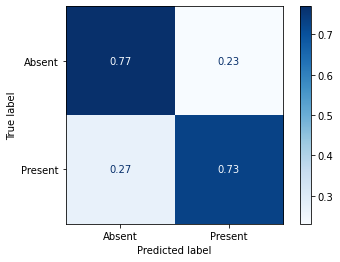

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'C': 250, 'solver': 'lbfgs'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### KNN

In [ ]:
sampler = SMOTEENN(random_state=12,sampling_strategy=0.5)# under over
x_resamp, y_resamp = sampler.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  1962 Present:  828 Porcentaje:  0.42201834862385323


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/knn_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=KNeighborsClassifier()
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'wei

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}",0.645478,0.623730,0.76,0.530957
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}",0.645478,0.623730,0.76,0.530957
"{'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}",0.645478,0.623730,0.76,0.530957
"{'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}",0.645478,0.623730,0.76,0.530957
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}",0.645478,0.623730,0.76,0.530957
"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}",0.645478,0.623730,0.76,0.530957
"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.649250,0.666678,0.70,0.598499
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.649250,0.666678,0.70,0.598499
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.649250,0.666678,0.70,0.598499
"{'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.649250,0.666678,0.70,0.598499


              precision    recall  f1-score   support

      Absent       0.91      0.60      0.72       533
     Present       0.25      0.70      0.36       100

    accuracy                           0.61       633
   macro avg       0.58      0.65      0.54       633
weighted avg       0.81      0.61      0.67       633



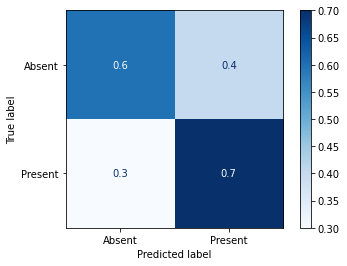

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

## f_classif

In [ ]:
cols_x=''' mfcc1 min, mfcc2 min, mfcc3 min, mfcc4 min, mfcc5 min, mfcc6 min, mfcc7 min, mfcc8 min, mfcc9 min, mfcc10 min, mfcc11 min, mfcc12 min, mfcc13 min, zcr min, rms min, sr90 min, sr10 min, sc min,
mfcc1 max, mfcc2 max, mfcc3 max, mfcc4 max, mfcc5 max, mfcc6 max, mfcc7 max, mfcc8 max, mfcc9 max, mfcc10 max, mfcc11 max, mfcc12 max, mfcc13 max, zcr max, rms max, sr90 max, sr10 max, sc max,
mfcc1 med, mfcc2 med, mfcc3 med, mfcc4 med, mfcc5 med, mfcc6 med, mfcc7 med, mfcc8 med, mfcc9 med, mfcc10 med, mfcc11 med, mfcc12 med, mfcc13 med, zcr med, rms med, sr90 med, sr10 med, sc med,
mfcc1 mean, mfcc2 mean, mfcc3 mean, mfcc4 mean, mfcc5 mean, mfcc6 mean, mfcc7 mean, mfcc8 mean, mfcc9 mean, mfcc10 mean, mfcc11 mean, mfcc12 mean, mfcc13 mean, zcr mean, rms mean, sr90 mean, sr10 mean, sc mean,
mfcc1 std, mfcc2 std, mfcc3 std, mfcc4 std, mfcc5 std, mfcc6 std, mfcc7 std, mfcc8 std, mfcc9 std, mfcc10 std, mfcc11 std, mfcc12 std, mfcc13 std, zcr std, rms std, sr90 std, sr10 std, sc std'''
cols_x = cols_x.replace('\n',' ').split(',')
x_full = df_nuevo[cols_x].values
y_full=[]
for i,val in df_nuevo[['AV', 'MV', 'PV', 'TV', 'Phc','#Murmur locations']].iterrows():
    if pd.isna(val['#Murmur locations']):
        y_full.append(0)
    else:
        locs = val['#Murmur locations'].split('+')
        #print(locs)
        if val[val==1].index.values[0] in locs:
            y_full.append(1)
        else:
            y_full.append(0)
    #print(val)
y_full=np.array(y_full)
# conjuntos de entrenamiento y prueba para todo el proceso  
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.20, random_state=12, stratify=y_full)

In [ ]:
select = SelectKBest(f_classif, k=70).fit(x_train, y_train) #seleccion de los 70 con mejor f-classif

In [ ]:
cols_selec=select.get_support(indices=True)
col_names = [cols_x[i] for i in cols_selec]
len(col_names)

70

In [ ]:
# se dejan solo las columnas necesarias, pero hay que tyener cuidado y recordar que se han quitado de x_train
x_train=x_train[:,cols_selec]
x_test=x_test[:,cols_selec]

### SVM

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/smv_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.752439,0.809000,0.70,0.804878
"{'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}",0.749625,0.805226,0.70,0.799250
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.748068,0.813330,0.68,0.816135
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.767439,0.813757,0.73,0.804878
"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.716520,0.826044,0.57,0.863039
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}",0.750891,0.832266,0.65,0.851782
"{'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}",0.743068,0.811711,0.67,0.816135
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.739325,0.821798,0.64,0.838649
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}",0.726820,0.810153,0.63,0.823640
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.711839,0.834403,0.54,0.883677


              precision    recall  f1-score   support

      Absent       0.94      0.80      0.87       533
     Present       0.41      0.73      0.53       100

    accuracy                           0.79       633
   macro avg       0.68      0.77      0.70       633
weighted avg       0.86      0.79      0.81       633



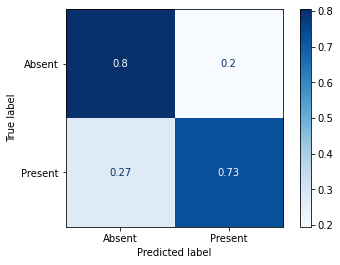

In [ ]:
clf=SVC(class_weight='balanced',random_state=12)
clf = make_pipeline(scaler, clf.set_params(**{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### MLP

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/mlp_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]#toco <0.65
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=MLPClassifier(max_iter=2000,early_stopping=True,n_iter_no_change=20,random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 6

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.698659,0.741771,0.69,0.707317
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.728368,0.787010,0.68,0.776735
"{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}",0.732120,0.792023,0.68,0.784240
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.726820,0.810153,0.63,0.823640
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.726820,0.810153,0.63,0.823640
"{'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.746191,0.810820,0.68,0.812383
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.738368,0.790136,0.70,0.776735
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.738368,0.790136,0.70,0.776735
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}",0.737420,0.773249,0.73,0.744841
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 80, 'learning_rate_init': 0.01}",0.688977,0.749731,0.65,0.727955


              precision    recall  f1-score   support

      Absent       0.93      0.81      0.87       533
     Present       0.40      0.68      0.51       100

    accuracy                           0.79       633
   macro avg       0.67      0.75      0.69       633
weighted avg       0.85      0.79      0.81       633



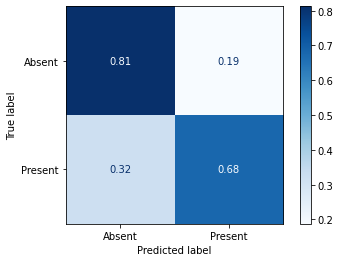

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### RF

In [ ]:
sampler = SMOTEENN(random_state=12,sampling_strategy=0.5)# under over
x_resamp, y_resamp = sampler.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  2016 Present:  845 Porcentaje:  0.4191468253968254


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/rf_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=RandomForestClassifier(class_weight='balanced',random_state=12) 
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}
kfold termin

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}",0.722448,0.814276,0.61,0.834897
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}",0.732448,0.817628,0.63,0.834897
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}",0.712439,0.796099,0.62,0.804878
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}",0.717129,0.802294,0.62,0.814259
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}",0.729634,0.813888,0.63,0.829268
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}",0.729325,0.818446,0.62,0.838649
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}",0.719625,0.795625,0.64,0.799250
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}",0.715882,0.805595,0.61,0.821764
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}",0.717448,0.812590,0.60,0.834897
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 10}",0.719625,0.795625,0.64,0.799250


              precision    recall  f1-score   support

      Absent       0.92      0.83      0.87       533
     Present       0.41      0.63      0.50       100

    accuracy                           0.80       633
   macro avg       0.67      0.73      0.68       633
weighted avg       0.84      0.80      0.81       633



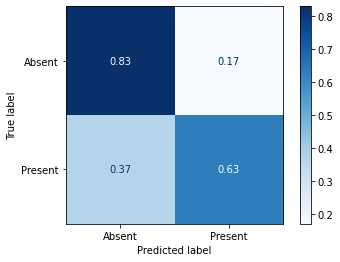

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### LR

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/lr_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 120, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'lbfgs'}
kfold terminado:  {'C': 100, 'solver': 'newton-cg'}
kfold terminado:  {'C': 100, 'solver': 'lbfgs'}
kfold terminado:  {'C': 120, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'newton-cg'}
kfold terminado:  {'C': 300, 'solver': 'newton-cg'}
kfold terminado:  {'C': 200, 'solver': 'lbfgs'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 120, 'solver': 'newton-cg'}",0.740235,0.77706,0.73,0.750469
"{'C': 150, 'solver': 'newton-cg'}",0.740235,0.77706,0.73,0.750469
"{'C': 150, 'solver': 'lbfgs'}",0.740235,0.77706,0.73,0.750469
"{'C': 100, 'solver': 'newton-cg'}",0.740235,0.77706,0.73,0.750469
"{'C': 100, 'solver': 'lbfgs'}",0.741173,0.77833,0.73,0.752345
"{'C': 120, 'solver': 'lbfgs'}",0.740235,0.77706,0.73,0.750469
"{'C': 250, 'solver': 'lbfgs'}",0.739296,0.77579,0.73,0.748593
"{'C': 250, 'solver': 'newton-cg'}",0.739296,0.77579,0.73,0.748593
"{'C': 300, 'solver': 'newton-cg'}",0.739296,0.77579,0.73,0.748593
"{'C': 200, 'solver': 'lbfgs'}",0.740235,0.77706,0.73,0.750469


              precision    recall  f1-score   support

      Absent       0.94      0.75      0.83       533
     Present       0.35      0.73      0.48       100

    accuracy                           0.75       633
   macro avg       0.65      0.74      0.66       633
weighted avg       0.84      0.75      0.78       633



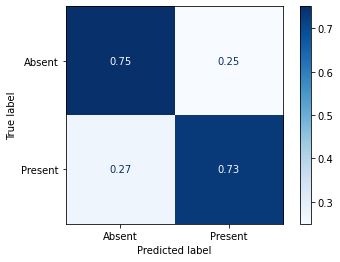

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'C': 120, 'solver': 'newton-cg'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### KNN

In [ ]:
sampler = SMOTEENN(random_state=12,sampling_strategy=0.5)# under over
x_resamp, y_resamp = sampler.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  2016 Present:  845 Porcentaje:  0.4191468253968254


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/knn_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=KNeighborsClassifier()
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'wei

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}",0.647992,0.652782,0.72,0.575985
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}",0.647992,0.652782,0.72,0.575985
"{'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}",0.647992,0.652782,0.72,0.575985
"{'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}",0.647992,0.652782,0.72,0.575985
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}",0.647992,0.652782,0.72,0.575985
"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}",0.647992,0.652782,0.72,0.575985
"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.662383,0.685653,0.70,0.624765
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.662383,0.685653,0.70,0.624765
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.662383,0.685653,0.70,0.624765
"{'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.662383,0.685653,0.70,0.624765


              precision    recall  f1-score   support

      Absent       0.92      0.62      0.74       533
     Present       0.26      0.70      0.38       100

    accuracy                           0.64       633
   macro avg       0.59      0.66      0.56       633
weighted avg       0.81      0.64      0.69       633



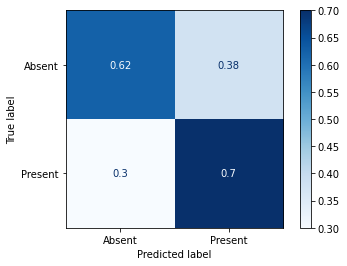

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

## Feature importance

In [ ]:
cols_x=''' mfcc1 min, mfcc2 min, mfcc3 min, mfcc4 min, mfcc5 min, mfcc6 min, mfcc7 min, mfcc8 min, mfcc9 min, mfcc10 min, mfcc11 min, mfcc12 min, mfcc13 min, zcr min, rms min, sr90 min, sr10 min, sc min,
mfcc1 max, mfcc2 max, mfcc3 max, mfcc4 max, mfcc5 max, mfcc6 max, mfcc7 max, mfcc8 max, mfcc9 max, mfcc10 max, mfcc11 max, mfcc12 max, mfcc13 max, zcr max, rms max, sr90 max, sr10 max, sc max,
mfcc1 med, mfcc2 med, mfcc3 med, mfcc4 med, mfcc5 med, mfcc6 med, mfcc7 med, mfcc8 med, mfcc9 med, mfcc10 med, mfcc11 med, mfcc12 med, mfcc13 med, zcr med, rms med, sr90 med, sr10 med, sc med,
mfcc1 mean, mfcc2 mean, mfcc3 mean, mfcc4 mean, mfcc5 mean, mfcc6 mean, mfcc7 mean, mfcc8 mean, mfcc9 mean, mfcc10 mean, mfcc11 mean, mfcc12 mean, mfcc13 mean, zcr mean, rms mean, sr90 mean, sr10 mean, sc mean,
mfcc1 std, mfcc2 std, mfcc3 std, mfcc4 std, mfcc5 std, mfcc6 std, mfcc7 std, mfcc8 std, mfcc9 std, mfcc10 std, mfcc11 std, mfcc12 std, mfcc13 std, zcr std, rms std, sr90 std, sr10 std, sc std'''
cols_x = cols_x.replace('\n',' ').split(',')
x_full = df_nuevo[cols_x].values
y_full=[]
for i,val in df_nuevo[['AV', 'MV', 'PV', 'TV', 'Phc','#Murmur locations']].iterrows():
    if pd.isna(val['#Murmur locations']):
        y_full.append(0)
    else:
        locs = val['#Murmur locations'].split('+')
        #print(locs)
        if val[val==1].index.values[0] in locs:
            y_full.append(1)
        else:
            y_full.append(0)
    #print(val)
y_full=np.array(y_full)
# conjuntos de entrenamiento y prueba para todo el proceso  
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.20, random_state=12, stratify=y_full)

In [ ]:
sampler = SMOTEENN(random_state=12,sampling_strategy=0.5)# under over
x_resamp, y_resamp = sampler.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  1933 Present:  839 Porcentaje:  0.4340403517847905


### RF

In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/rf_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=RandomForestClassifier(class_weight='balanced',random_state=12) 
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}
kfold termin

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}",0.717129,0.802294,0.62,0.814259
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}",0.718068,0.803533,0.62,0.816135
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}",0.738068,0.810086,0.66,0.816135
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}",0.726191,0.804331,0.64,0.812383
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}",0.711191,0.799407,0.61,0.812383
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}",0.734944,0.810952,0.65,0.819887
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}",0.710253,0.798171,0.61,0.810507
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}",0.726201,0.819250,0.61,0.842402
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}",0.726820,0.810153,0.63,0.823640
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 10}",0.690563,0.787066,0.58,0.801126


              precision    recall  f1-score   support

      Absent       0.93      0.82      0.87       533
     Present       0.40      0.66      0.50       100

    accuracy                           0.79       633
   macro avg       0.66      0.74      0.68       633
weighted avg       0.84      0.79      0.81       633



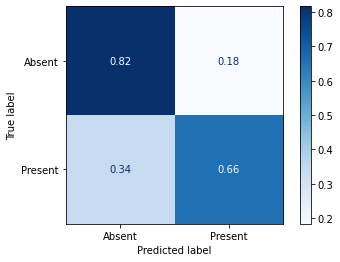

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

In [ ]:
cols_selec = np.flip(np.argsort(clf['randomforestclassifier'].feature_importances_))[:70]
col_names = [cols_x[i] for i in cols_selec]

In [ ]:
# se dejan solo las columnas necesarias, pero hay que tyener cuidado y recordar que se han quitado de x_train
x_train=x_train[:,cols_selec]
x_test=x_test[:,cols_selec]

### SVM

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/smv_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.747430,0.791983,0.72,0.774859
"{'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}",0.728049,0.776280,0.70,0.756098
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.754006,0.816202,0.69,0.818011
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.754306,0.796059,0.73,0.778612
"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.738705,0.830954,0.62,0.857411
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}",0.724944,0.807666,0.63,0.819887
"{'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}",0.760572,0.825019,0.69,0.831144
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.717129,0.802294,0.62,0.814259
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}",0.747448,0.822612,0.66,0.834897
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.731839,0.841600,0.58,0.883677


              precision    recall  f1-score   support

      Absent       0.93      0.83      0.88       533
     Present       0.43      0.69      0.53       100

    accuracy                           0.81       633
   macro avg       0.68      0.76      0.71       633
weighted avg       0.86      0.81      0.83       633



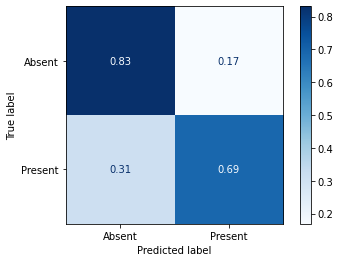

In [ ]:
clf=SVC(class_weight='balanced',random_state=12)
clf = make_pipeline(scaler, clf.set_params(**{'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}	))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

## Combinacion

Los modelos finales se prueban con la tecnica de muestreo que mejor funciono para ellos, y seleccionando las 49 caracteriticas que aparecen repetidas en los 3 metodos de seleccion

In [ ]:
cols_x=''' mfcc1 min, mfcc2 min, mfcc3 min, mfcc4 min, mfcc5 min, mfcc6 min, mfcc7 min, mfcc8 min, mfcc9 min, mfcc10 min, mfcc11 min, mfcc12 min, mfcc13 min, zcr min, rms min, sr90 min, sr10 min, sc min,
mfcc1 max, mfcc2 max, mfcc3 max, mfcc4 max, mfcc5 max, mfcc6 max, mfcc7 max, mfcc8 max, mfcc9 max, mfcc10 max, mfcc11 max, mfcc12 max, mfcc13 max, zcr max, rms max, sr90 max, sr10 max, sc max,
mfcc1 med, mfcc2 med, mfcc3 med, mfcc4 med, mfcc5 med, mfcc6 med, mfcc7 med, mfcc8 med, mfcc9 med, mfcc10 med, mfcc11 med, mfcc12 med, mfcc13 med, zcr med, rms med, sr90 med, sr10 med, sc med,
mfcc1 mean, mfcc2 mean, mfcc3 mean, mfcc4 mean, mfcc5 mean, mfcc6 mean, mfcc7 mean, mfcc8 mean, mfcc9 mean, mfcc10 mean, mfcc11 mean, mfcc12 mean, mfcc13 mean, zcr mean, rms mean, sr90 mean, sr10 mean, sc mean,
mfcc1 std, mfcc2 std, mfcc3 std, mfcc4 std, mfcc5 std, mfcc6 std, mfcc7 std, mfcc8 std, mfcc9 std, mfcc10 std, mfcc11 std, mfcc12 std, mfcc13 std, zcr std, rms std, sr90 std, sr10 std, sc std'''
cols_x = cols_x.replace('\n',' ').split(',')
x_full = df_nuevo[cols_x].values
y_full=[]
for i,val in df_nuevo[['AV', 'MV', 'PV', 'TV', 'Phc','#Murmur locations']].iterrows():
    if pd.isna(val['#Murmur locations']):
        y_full.append(0)
    else:
        locs = val['#Murmur locations'].split('+')
        #print(locs)
        if val[val==1].index.values[0] in locs:
            y_full.append(1)
        else:
            y_full.append(0)
    #print(val)
y_full=np.array(y_full)
# conjuntos de entrenamiento y prueba para todo el proceso  
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.20, random_state=12, stratify=y_full)

In [ ]:
# Filtro con std
scaler=MinMaxScaler((0,1))
x_t2=scaler.fit_transform(x_train)
x_std=x_t2.std(axis=0)
cols_selec_var=np.where((x_std>0.1))[0]
col_names_var = [cols_x[i] for i in cols_selec_var]

In [ ]:
# Filtro por f_classif
select = SelectKBest(f_classif, k=70).fit(x_train, y_train) #seleccion de los 70 con mejor f-classif
cols_selec_fc=select.get_support(indices=True)
col_names_fc = [cols_x[i] for i in cols_selec_fc]

In [ ]:
#filtro Feature_importance
sampler = SMOTEENN(random_state=12,sampling_strategy=0.5)# under over
x_resamp, y_resamp = sampler.fit_resample(x_train, y_train)
scaler = MinMaxScaler((0,1))
clf=RandomForestClassifier(class_weight='balanced',random_state=12) 

clf = make_pipeline(scaler, 
                    clf.set_params(**{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}))
clf.fit(x_resamp, y_resamp)
cols_selec_fi = np.flip(np.argsort(clf['randomforestclassifier'].feature_importances_))[:70]
col_names_fi = [cols_x[i] for i in cols_selec_fi]

In [ ]:
np.sort(cols_selec_var),np.sort(cols_selec_fc),np.sort(cols_selec_fi)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
        18, 19, 21, 22, 23, 25, 26, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58,
        59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 71, 72, 73, 74, 75, 76, 78,
        82, 83, 84, 85, 86, 87, 89]),
 array([ 0,  1,  2,  4,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22,
        23, 24, 26, 27, 28, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62,
        63, 64, 65, 66, 67, 68, 70, 71, 73, 77, 78, 82, 83, 84, 85, 86, 87,
        88, 89]),
 array([ 0,  1,  2,  3,  4, 10, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24,
        25, 26, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 48,
        49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 64, 65, 66, 67, 68, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87,
        88, 89]))

In [ ]:
cols_selec=np.intersect1d(cols_selec_var, cols_selec_fi)
cols_selec=np.intersect1d(cols_selec, cols_selec_fc)

In [ ]:
col_names = [cols_x[i] for i in cols_selec]
len(col_names)

49

In [ ]:
print(col_names)

[' mfcc1 min', ' mfcc2 min', ' mfcc3 min', ' mfcc5 min', ' mfcc11 min', ' mfcc13 min', ' zcr min', ' sr90 min', ' sr10 min', ' sc min', ' mfcc5 max', ' mfcc6 max', ' mfcc9 max', ' mfcc13 max', ' zcr max', ' sr10 max', ' sc max', ' mfcc1 med', ' mfcc3 med', ' mfcc4 med', ' mfcc5 med', ' mfcc6 med', ' mfcc7 med', ' mfcc8 med', ' mfcc9 med', ' mfcc11 med', ' mfcc13 med', ' zcr med', ' sr10 med', ' sc med', ' mfcc1 mean', ' mfcc3 mean', ' mfcc4 mean', ' mfcc5 mean', ' mfcc6 mean', ' mfcc7 mean', ' mfcc11 mean', ' mfcc12 mean', ' mfcc13 mean', ' zcr mean', ' sc mean', ' mfcc2 std', ' mfcc7 std', ' mfcc11 std', ' mfcc12 std', ' zcr std', ' rms std', ' sr90 std', ' sc std']


In [ ]:
# se dejan solo las columnas necesarias, pero hay que tyener cuidado y recordar que se han quitado de x_train
x_train=x_train[:,cols_selec]
x_test=x_test[:,cols_selec]

### SVM

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/smv_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=SVC(class_weight='balanced',random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
kfold terminado:  {'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}
kfold terminado:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.747749,0.802712,0.70,0.795497
"{'C': 50, 'gamma': 'auto', 'kernel': 'rbf'}",0.748687,0.803969,0.70,0.797373
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}",0.753386,0.825520,0.67,0.836773
"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.741191,0.809206,0.67,0.812383
"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}",0.732148,0.837065,0.59,0.874296
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}",0.749015,0.829747,0.65,0.848030
"{'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}",0.747139,0.827231,0.65,0.844278
"{'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}",0.731201,0.820941,0.62,0.842402
"{'C': 0.8, 'gamma': 'scale', 'kernel': 'poly'}",0.751829,0.833528,0.65,0.853659
"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.722777,0.839277,0.56,0.885553


              precision    recall  f1-score   support

      Absent       0.93      0.84      0.88       533
     Present       0.44      0.67      0.53       100

    accuracy                           0.81       633
   macro avg       0.68      0.75      0.70       633
weighted avg       0.85      0.81      0.83       633



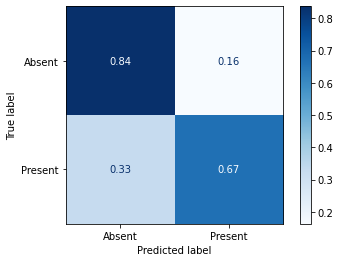

In [ ]:
clf=SVC(class_weight='balanced',random_state=12)
clf = make_pipeline(scaler, clf.set_params(**{'C': 0.3, 'gamma': 'scale', 'kernel': 'poly'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### MLP

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/mlp_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]#toco <0.65
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=MLPClassifier(max_iter=2000,early_stopping=True,n_iter_no_change=20,random_state=12)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}
kfold terminado:  {'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 6

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'activation': 'relu', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.760544,0.778197,0.78,0.741088
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}",0.759315,0.813111,0.71,0.808630
"{'activation': 'relu', 'batch_size': 200, 'hidden_layer_sizes': 40, 'learning_rate_init': 0.01}",0.750882,0.817097,0.68,0.821764
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.756501,0.809330,0.71,0.803002
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.756501,0.809330,0.71,0.803002
"{'activation': 'tanh', 'batch_size': 600, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.729953,0.824238,0.61,0.849906
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.759944,0.819074,0.70,0.819887
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.01}",0.759944,0.819074,0.70,0.819887
"{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}",0.765882,0.821945,0.71,0.821764
"{'activation': 'tanh', 'batch_size': 400, 'hidden_layer_sizes': 80, 'learning_rate_init': 0.01}",0.759944,0.819074,0.70,0.819887


              precision    recall  f1-score   support

      Absent       0.94      0.82      0.88       533
     Present       0.43      0.71      0.53       100

    accuracy                           0.80       633
   macro avg       0.68      0.77      0.70       633
weighted avg       0.86      0.80      0.82       633



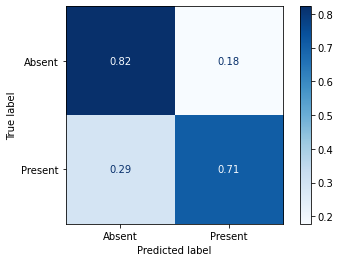

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'activation': 'tanh', 'batch_size': 200, 'hidden_layer_sizes': 60, 'learning_rate_init': 0.01}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### RF

In [ ]:
sampler = SMOTEENN(random_state=12,sampling_strategy=0.5)# under over
x_resamp, y_resamp = sampler.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  2039 Present:  824 Porcentaje:  0.4041196665031878


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/rf_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=RandomForestClassifier(class_weight='balanced',random_state=12) 
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}
kfold terminado:  {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}
kfold termin

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 80}",0.718068,0.803533,0.62,0.816135
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}",0.724006,0.806423,0.63,0.818011
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 100}",0.715253,0.799815,0.62,0.810507
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 80}",0.713377,0.797337,0.62,0.806754
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 200}",0.713068,0.801881,0.61,0.816135
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 100}",0.715882,0.805595,0.61,0.821764
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 100, 'n_estimators': 20}",0.713068,0.801881,0.61,0.816135
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 20}",0.717129,0.802294,0.62,0.814259
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 70, 'n_estimators': 80}",0.714944,0.804356,0.61,0.819887
"{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 10}",0.720253,0.801454,0.63,0.810507


              precision    recall  f1-score   support

      Absent       0.92      0.82      0.87       533
     Present       0.39      0.63      0.48       100

    accuracy                           0.79       633
   macro avg       0.66      0.72      0.68       633
weighted avg       0.84      0.79      0.81       633



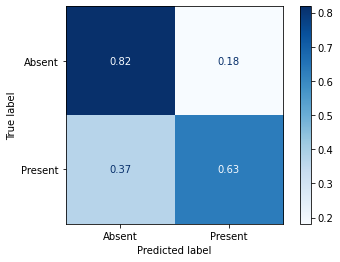

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 80, 'n_estimators': 100}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### LR

In [ ]:
oversample = SMOTE(random_state=12)#Over
x_resamp, y_resamp = oversample.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  4262 Present:  2131 Porcentaje:  0.5


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/lr_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=LogisticRegression(class_weight='balanced',random_state=12,max_iter=5000)
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'C': 120, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'newton-cg'}
kfold terminado:  {'C': 150, 'solver': 'lbfgs'}
kfold terminado:  {'C': 100, 'solver': 'newton-cg'}
kfold terminado:  {'C': 100, 'solver': 'lbfgs'}
kfold terminado:  {'C': 120, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'lbfgs'}
kfold terminado:  {'C': 250, 'solver': 'newton-cg'}
kfold terminado:  {'C': 300, 'solver': 'newton-cg'}
kfold terminado:  {'C': 200, 'solver': 'lbfgs'}


,balanced_acc_test,f1_test,recall_test,specificity_test
"{'C': 120, 'solver': 'newton-cg'}",0.751182,0.797032,0.72,0.782364
"{'C': 150, 'solver': 'newton-cg'}",0.750244,0.795770,0.72,0.780488
"{'C': 150, 'solver': 'lbfgs'}",0.751182,0.797032,0.72,0.782364
"{'C': 100, 'solver': 'newton-cg'}",0.751182,0.797032,0.72,0.782364
"{'C': 100, 'solver': 'lbfgs'}",0.751182,0.797032,0.72,0.782364
"{'C': 120, 'solver': 'lbfgs'}",0.751182,0.797032,0.72,0.782364
"{'C': 250, 'solver': 'lbfgs'}",0.750244,0.795770,0.72,0.780488
"{'C': 250, 'solver': 'newton-cg'}",0.750244,0.795770,0.72,0.780488
"{'C': 300, 'solver': 'newton-cg'}",0.750244,0.795770,0.72,0.780488
"{'C': 200, 'solver': 'lbfgs'}",0.750244,0.795770,0.72,0.780488


              precision    recall  f1-score   support

      Absent       0.94      0.78      0.85       533
     Present       0.38      0.72      0.50       100

    accuracy                           0.77       633
   macro avg       0.66      0.75      0.68       633
weighted avg       0.85      0.77      0.80       633



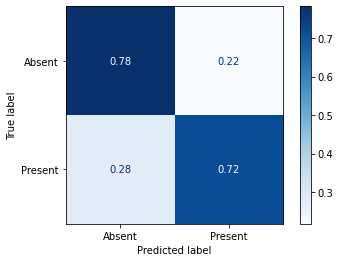

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'C': 120, 'solver': 'newton-cg'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()

### KNN

In [ ]:
sampler = SMOTEENN(random_state=12,sampling_strategy=0.5)# under over
x_resamp, y_resamp = sampler.fit_resample(x_train, y_train)
print('Datos Entrenamiento:\n', 'Cantidad: ', len(y_resamp),'Present: ',sum(y_resamp), 'Porcentaje: ',sum(y_resamp)/len(y_resamp))

Datos Entrenamiento:
 Cantidad:  2039 Present:  824 Porcentaje:  0.4041196665031878


In [ ]:
# se seleccionan solo los 10 mejores en balanced_acc_mean_test
df_model=pd.read_csv('/content/drive/MyDrive/Proyectos_Materias/PGAD_murnur_detection/results/exploracion_simple/knn_simple.csv')
df_select=df_model.sort_values('balanced_acc_mean_test',ascending=False)[:10]
params= [ast.literal_eval(i) for i in df_select['Unnamed: 0'].values.tolist()]

In [ ]:
scaler = MinMaxScaler((0,1))
clf=KNeighborsClassifier()
df_model=model_comparison_test(x_resamp, x_test, y_resamp, y_test,clf,scaler,params,random_state=12)
df_model

kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}
kfold terminado:  {'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'wei

,balanced_acc_test,f1_test,recall_test,specificity_test
"{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}",0.675507,0.687116,0.73,0.621013
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 3, 'weights': 'uniform'}",0.675507,0.687116,0.73,0.621013
"{'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 3, 'weights': 'uniform'}",0.675507,0.687116,0.73,0.621013
"{'algorithm': 'ball_tree', 'leaf_size': 40, 'n_neighbors': 3, 'weights': 'uniform'}",0.675507,0.687116,0.73,0.621013
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 3, 'weights': 'uniform'}",0.675507,0.687116,0.73,0.621013
"{'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}",0.675507,0.687116,0.73,0.621013
"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.667392,0.704069,0.68,0.654784
"{'algorithm': 'ball_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.667392,0.704069,0.68,0.654784
"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 2, 'weights': 'distance'}",0.667392,0.704069,0.68,0.654784
"{'algorithm': 'kd_tree', 'leaf_size': 90, 'n_neighbors': 2, 'weights': 'distance'}",0.667392,0.704069,0.68,0.654784


              precision    recall  f1-score   support

      Absent       0.92      0.62      0.74       533
     Present       0.27      0.73      0.39       100

    accuracy                           0.64       633
   macro avg       0.60      0.68      0.57       633
weighted avg       0.82      0.64      0.69       633



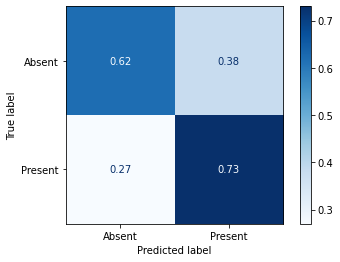

In [ ]:
clf = make_pipeline(scaler, 
                    clf.set_params(**{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'}))
clf.fit(x_resamp, y_resamp)
y_pred=clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Absent','Present']))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Absent','Present'],normalize='true',cmap='Blues')
plt.show()